<a id="1"></a>
<h1 style='background:deeppink; border:0; color:white'><center>1.Data loading and overview</center></h1>

In [83]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from matplotlib_venn import venn2
from matplotlib import pyplot
import seaborn as sns
from tqdm import tqdm
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
DATA_DIR = Path("/home/knikaido/work/Ventilator-Pressure-Prediction/data/ventilator-pressure-prediction")
OUTPUT_DIR = Path('./output/')

In [76]:
train = pd.read_csv(DATA_DIR / 'train.csv',index_col=0)
test  = pd.read_csv(DATA_DIR / 'test.csv', index_col=0)

/usr/local/lib/python3.8/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [77]:
train['RC'] = train['R'].astype(str) + '_' + train['C'].astype(str)

In [78]:
train['num'] = train.groupby(['breath_id', 'RC']).cumcount()
u_in_table = pd.pivot_table(train, index=['breath_id', 'RC'], columns='num', values='u_in')
u_in_table = u_in_table.reset_index()
u_in_table

num    breath_id     RC          0           1          2          3  \
0              1  20_50   0.083334   18.383041  22.509278  22.808822   
1              2  20_20  12.184338   13.980205  12.574163  11.730537   
2              3  50_20   0.000000    7.187242  13.338781  17.111335   
3              4  50_50   0.000000    1.262539   4.001352   6.379411   
4              5   5_50  21.424375   28.504653  29.353025  30.502095   
...          ...    ...        ...         ...        ...        ...   
75445     125740  50_50   0.000000    0.000000   0.673913   1.700763   
75446     125742  20_10  85.630231  100.000000  81.566813   0.000000   
75447     125743  20_10   0.000000    0.000000   0.000000   0.950177   
75448     125745  50_50  15.564236   23.588836  20.298696  12.326433   
75449     125749  50_10   6.030572   25.504196  21.614707  16.266744   

num            4          5          6          7  ...        70        71  \
0      25.355850  27.259866  27.127486  26.807732  ...  4.940237  4.949604   
1      12.124229  11.055636  10.774428  11.111878  ...  4.946820  4.955128   
2      18.353980  17.417672  15.353111  13.641899  ...  4.876171  4.894445   
3       8.295194   9.790410  10.874443  13.336506  ...  4.879581  4.897809   
4      31.024647  32.224651  32.364788  32.858346  ...  4.954280  4.961622   
...          ...        ...        ...        ...  ...       ...       ...   
75445   2.619867   3.397223   4.030364   4.540090  ...  4.951377  4.958965   
75446  23.328401  89.819686   0.000000   0.000000  ...  4.937050  4.946832   
75447   3.256712   4.678061   4.628657   4.970097  ...  4.935777  4.945808   
75448  10.807906  11.630441  10.997722   9.542468  ...  4.877733  4.895692   
75449  16.101221  14.700098  13.117684  13.573873  ...  1.367263  1.362261   

num          72        73        74        75        76        77        78  \
0      4.957466  4.964136  4.969730  4.974474  4.978481  4.981847  4.984683   
1      4.962164  4.968085  4.973087  4.977307  4.980860  4.983857  4.986382   
2      4.910021  4.923308  4.934620  4.944269  4.952485  4.959494  4.965451   
3      4.912832  4.925605  4.936515  4.946119  4.954007  4.960767  4.966532   
4      4.967670  4.972735  4.977117  4.980725  4.983751  4.986374  4.988504   
...         ...       ...       ...       ...       ...       ...       ...   
75445  4.965437  4.970984  4.975529  4.979396  4.982703  4.985436  4.987730   
75446  4.955088  4.962065  4.967939  4.972923  4.977126  4.980671  4.983671   
75447  4.954189  4.961282  4.967358  4.972427  4.976734  4.980354  4.983397   
75448  4.911043  4.924128  4.935280  4.944776  4.952874  4.959785  4.965696   
75449  1.357586  1.353205  1.420711  1.489714  1.488497  1.558978  1.272663   

num          79  
0      4.987079  
1      4.988518  
2      4.970562  
3      4.971585  
4      4.990306  
...         ...  
75445  4.989706  
75446  4.986201  
75447  4.985969  
75448  4.970727  
75449  1.482739  

[75450 rows x 82 columns]

In [79]:
def search_similar_id(target_id, th):
    """
    Find a breath_id with a similar u_in pattern.

    Parameters
    ----------
    target_id : int
        Target breath_id
    th : float
        Cosine similarity threshold

    Returns
    -------
    similar_id : list
        List of ids with similar patterns
    """
    
    if target_id in u_in_table['breath_id'].tolist():
        target_rc = u_in_table[u_in_table['breath_id']==target_id]['RC'].values[0]
        target_vec = u_in_table[u_in_table['breath_id']==target_id].to_numpy()[:,2:]

        refer_table = u_in_table[(u_in_table['RC']==target_rc) & (u_in_table['breath_id']!=target_id)].reset_index(drop=True)
        refer_vec = refer_table.to_numpy()[:,2:]
        breaths = refer_table['breath_id'].unique().tolist()
        breath_map = {i:b for i,b in enumerate(breaths)}

        cs = cosine_similarity(target_vec, refer_vec)[0]
        similar_idx = list(np.where(cs>th)[0])
        similar_id = [breath_map[i] for i in similar_idx]
    
    else:
        similar_id = []
        
    return similar_id

In [171]:
def viz_similar_id(target_id, th=0.99):
    """
    Visualize and compare u_in and pressure of breath_id with similar patterns.

    Parameters
    ----------
    target_id : int
        Target breath_id
    th : float
        Cosine similarity threshold
    """
    rc = u_in_table[u_in_table['breath_id']==target_id]['RC'].values[0]
    similar_ids = search_similar_id(target_id, th)
    viz_id = [target_id] + similar_ids
    
    fig, axes = plt.subplots(figsize=(16, 9), nrows=2,sharex=True)
    for i, id_ in enumerate(viz_id):
        lw = 5 if i ==  0 else 1
        tmp = train[train['breath_id']==id_].copy()
        axes[0].plot(tmp['time_step'], tmp['u_in'], label='breath_id : ' + str(id_), lw=lw)
        axes[1].plot(tmp['time_step'], tmp['pressure'], label='breath_id : ' + str(id_), lw=lw)
#         axes[0].legend(loc='upper right')
        axes[0].grid(color='g', linestyle=':', linewidth=0.3)
        axes[0].set_title('u_in')
#         axes[1].legend(loc='upper right')
        axes[1].grid(color='g', linestyle=':', linewidth=0.3)
        axes[1].set_title('pressure')
        fig.suptitle(f'target_id : {target_id}  (RC={rc})')
        
    return u_in_table[u_in_table['breath_id'].isin(viz_id)]

In [173]:
near_table = viz_similar_id(target_id=924)
# near_table

In [169]:
near_table

num    breath_id     RC         0          1          2          3          4  \
41            49  50_10  1.235291  19.226158  20.391391  15.051625  11.087818   
119          167  50_10  0.000000  22.900243  31.923252  31.020356  26.833107   
124          175  50_10  1.053628  18.344089  20.843884  16.444929  12.332393   
430          658  50_10  1.831224  32.392785  39.917600  33.172732  22.416976   
583          924  50_10  1.287146  20.455316  22.340674  16.904128  12.193892   
...          ...    ...       ...        ...        ...        ...        ...   
74061     123415  50_10  3.987769  22.714710  23.930765  16.396026  10.891169   
74134     123524  50_10  0.565830  13.710284  17.598257  17.557850  16.595759   
74414     124002  50_10  2.553262  25.473501  31.402669  28.357065  23.622630   
74546     124215  50_10  0.000000  13.270921  15.901932  12.845725   9.979974   
75345     125574  50_10  3.648423  38.340400  46.079336  36.945976  25.158617   

num            5          6          7  ...        70        71        72  \
41     11.299870  11.333850   8.418658  ...  4.861507  4.881767  4.899078   
119    23.399703  19.802951  16.518710  ...  4.863754  4.883677  4.900674   
124    11.601500  11.616719  11.377043  ...  4.860413  4.880797  4.898222   
430    14.680692   9.865234   7.832275  ...  4.860891  4.881217  4.898564   
583    11.463152  12.293911  11.564763  ...  4.861394  4.881658  4.898988   
...          ...        ...        ...  ...       ...       ...       ...   
74061  10.957787  12.102413  11.330971  ...  4.866783  4.886283  4.902954   
74134  16.396505  16.121399  14.876478  ...  4.859943  4.880411  4.897901   
74414  20.994312  18.800965  16.976638  ...  4.865733  4.885374  4.902143   
74546  10.378807   9.987850   8.545093  ...  4.863778  4.883696  4.900692   
75345  17.262417  12.787442  11.698562  ...  4.865599  4.885268  4.902075   

num          73        74        75        76        77        78        79  
41     4.913860  4.926482  4.937253  4.946432  4.954282  4.960972  4.966695  
119    4.915193  4.927598  4.938189  4.947225  4.954941  4.961528  4.967155  
124    4.913099  4.925800  4.936633  4.945892  4.953800  4.960554  4.966324  
430    4.913390  4.926060  4.936872  4.946091  4.953976  4.960707  4.966456  
583    4.913782  4.926395  4.937172  4.946354  4.954205  4.960908  4.966626  
...         ...       ...       ...       ...       ...       ...       ...  
74061  4.917152  4.929269  4.939628  4.948481  4.956006  4.962445  4.967937  
74134  4.912811  4.925555  4.936440  4.945742  4.953672  4.960460  4.966242  
74414  4.916467  4.928705  4.939123  4.948025  4.955622  4.962116  4.967653  
74546  4.915221  4.927626  4.938200  4.947235  4.954959  4.961548  4.967173  
75345  4.916421  4.928653  4.939108  4.948021  4.955624  4.962117  4.967660  

[344 rows x 82 columns]

In [155]:
train_near = train[train['breath_id'].isin(near_table['breath_id'].unique())]

In [156]:
b_ids = train_near['breath_id'].unique()
plt.figure(figsize=(15, 10))
for i, b_id in enumerate(b_ids):
    tmp_df = train_near[train_near['breath_id']==b_id]
    plt.plot(np.arange(len(tmp_df['time_step'])), tmp_df['time_step'].diff())
plt.legend()

No handles with labels found to put in legend.


In [65]:
colors = [plt.cm.tab10(i) for i in range(20)]

# R=50, C=50

In [56]:
train_rc = train[(train['R']==50) & (train['C']==50)].reset_index()

In [59]:
train_rc_g_by = train_rc.groupby('breath_id')['pressure'].apply(list).apply(pd.Series)

In [61]:
kmeans = KMeans(n_clusters=2, random_state=777)

In [62]:
kmeans.fit(train_rc_g_by.values)

KMeans(n_clusters=2, random_state=777)

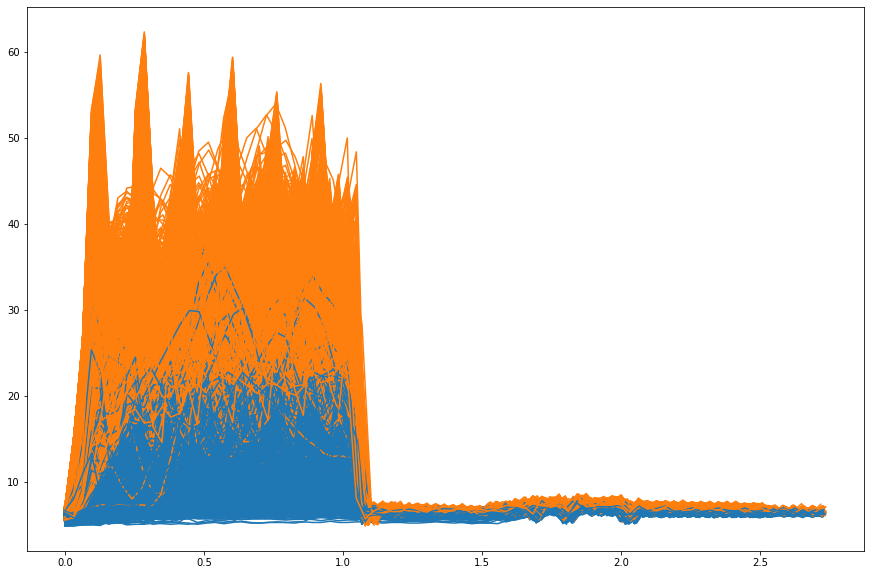

In [66]:
train_rc = train[(train['R']==50) & (train['C']==50)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for i, b_id in enumerate(b_ids):
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure', color=colors[kmeans.labels_[i]])

In [71]:
tmp_df

id  breath_id   R   C  time_step        u_in  u_out   pressure
3440  27281        512  50  50   0.000000  100.000000      0   6.470211
3441  27282        512  50  50   0.031686  100.000000      0  14.836166
3442  27283        512  50  50   0.063495   62.670972      0  26.084510
3443  27284        512  50  50   0.095256    0.000000      0  49.706030
3444  27285        512  50  50   0.127152    0.000000      0  49.635728
...     ...        ...  ..  ..        ...         ...    ...        ...
3515  27356        512  50  50   2.381324    4.944421      1   7.173232
3516  27357        512  50  50   2.413082    4.952581      1   7.454441
3517  27358        512  50  50   2.444758    4.959527      1   6.892024
3518  27359        512  50  50   2.476407    4.965451      1   6.470211
3519  27360        512  50  50   2.508119    4.970516      1   7.313837

[80 rows x 8 columns]

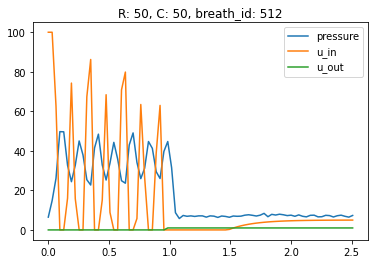

In [73]:
R = tmp_df.iloc[0, 2]
C = tmp_df.iloc[0, 3]
plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')
plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')
plt.plot(tmp_df['time_step'], tmp_df['u_out'], label='u_out')
plt.title(f'R: {R}, C: {C}, breath_id: {b_id}')
plt.legend()

In [74]:
train_rc = train[(train['R']==50) & (train['C']==50)].reset_index()
# b_ids = train_rc[train_rc['u_in']>=100]['breath_id'].unique()
b_ids = train_rc['breath_id'].unique()

plt.figure(figsize=(15, 10))
u_out0_len = []
for i, b_id in enumerate(b_ids):
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in', color=colors[kmeans.labels_[i]])
    u_out0_len.append(tmp_df[tmp_df['u_out']==0]['time_step'].values[-1])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    8189.000000
mean        0.970103
std         0.013364
min         0.931081
25%         0.960053
50%         0.965086
75%         0.984118
max         0.999466
dtype: float64

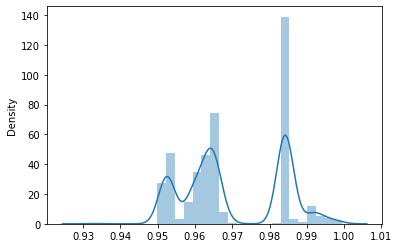

In [43]:
sns.distplot(u_out0_len)
pd.Series(u_out0_len).describe()

# R=50, C=20

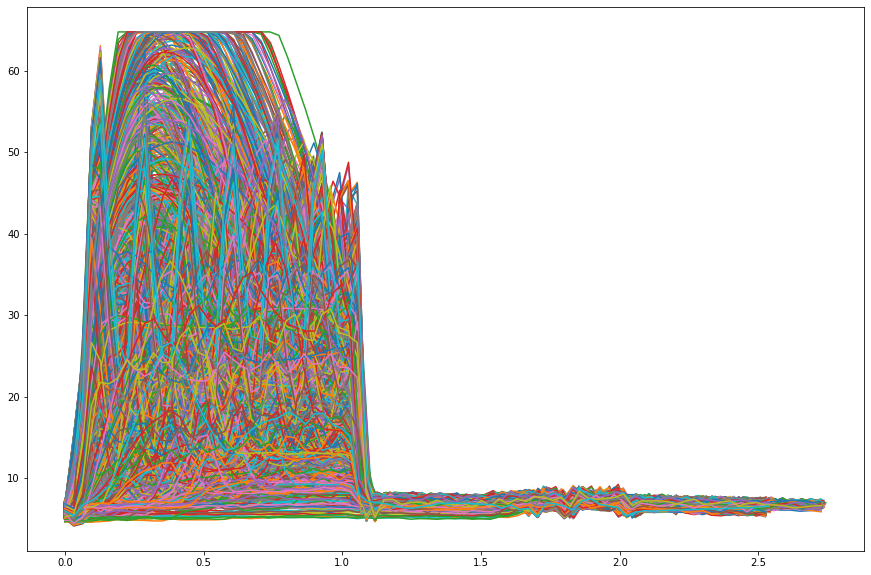

In [20]:
train_rc = train[(train['R']==50) & (train['C']==20)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')

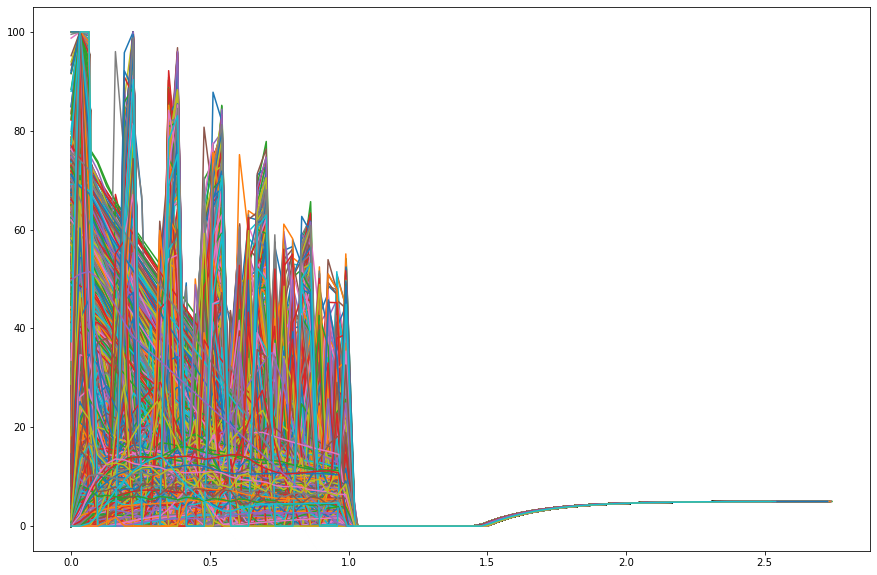

In [44]:
train_rc = train[(train['R']==50) & (train['C']==20)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
u_out0_len = []
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')
    u_out0_len.append(tmp_df[tmp_df['u_out']==0]['time_step'].values[-1])

In [45]:
sns.distplot(u_out0_len)
pd.Series(u_out0_len).describe()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    8260.000000
mean        0.977293
std         0.013445
min         0.930772
25%         0.964739
50%         0.968238
75%         0.990183
max         0.999621
dtype: float64

# R=50, C=10

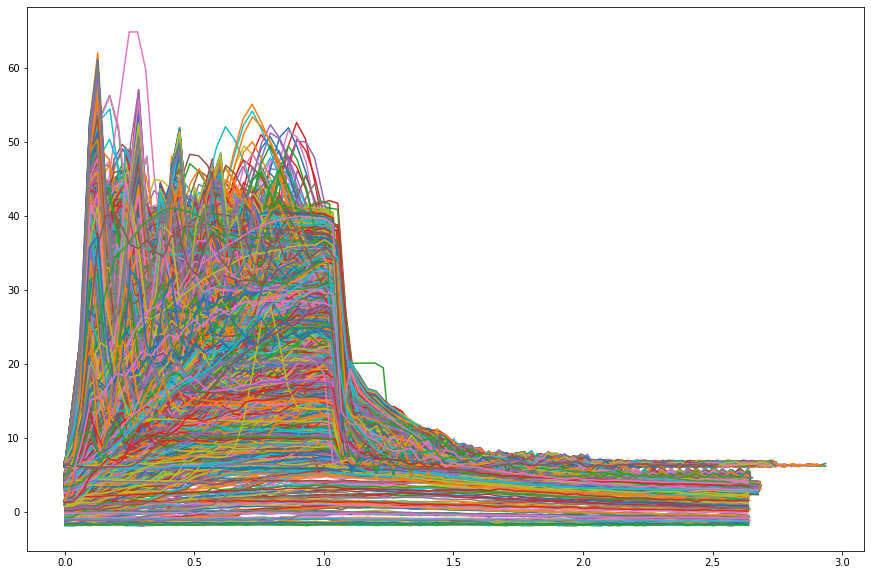

In [21]:
train_rc = train[(train['R']==50) & (train['C']==10)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')

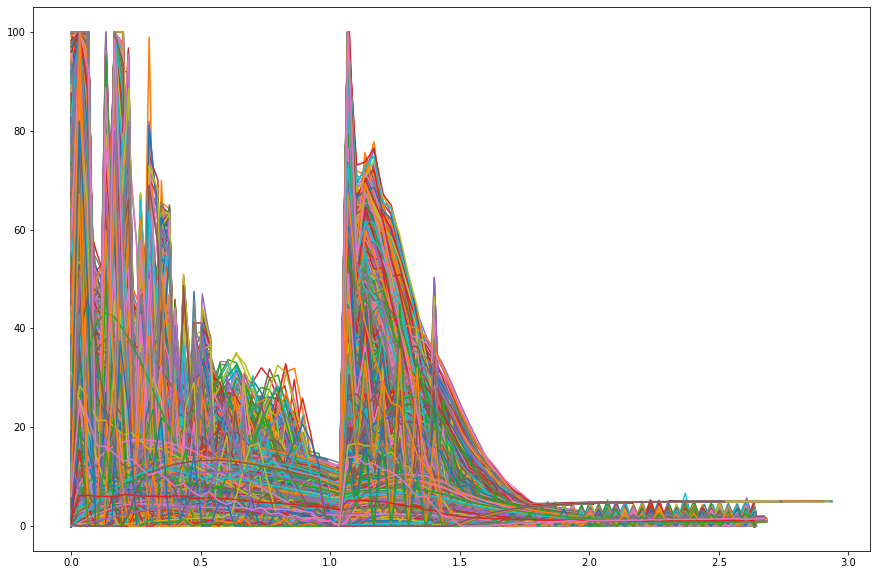

In [46]:
train_rc = train[(train['R']==50) & (train['C']==10)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
u_out0_len = []
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')
    u_out0_len.append(tmp_df[tmp_df['u_out']==0]['time_step'].values[-1])

In [47]:
sns.distplot(u_out0_len)
pd.Series(u_out0_len).describe()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    13677.000000
mean         0.971051
std          0.011332
min          0.790936
25%          0.964770
50%          0.968887
75%          0.980588
max          0.999748
dtype: float64

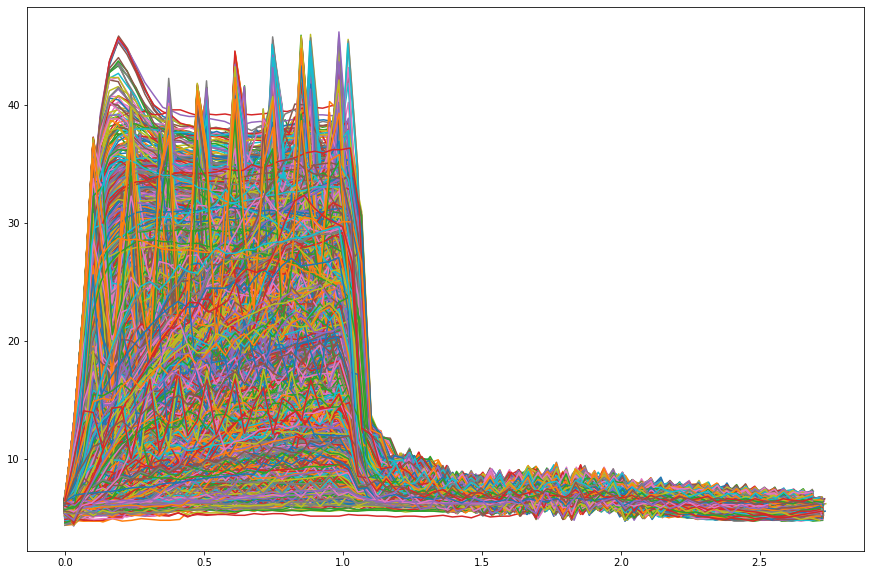

In [17]:
train_rc = train[(train['R']==20) & (train['C']==50)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')

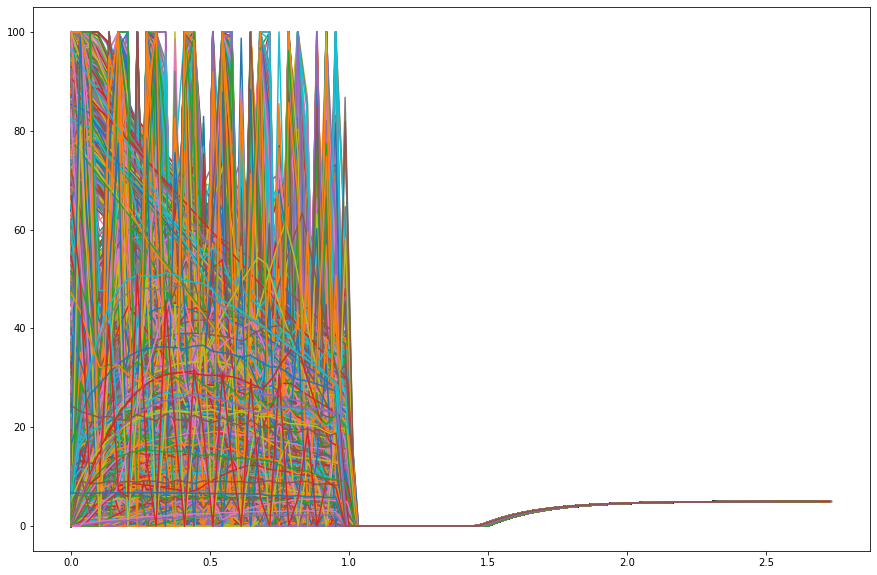

In [75]:
train_rc = train[(train['R']==20) & (train['C']==50)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')

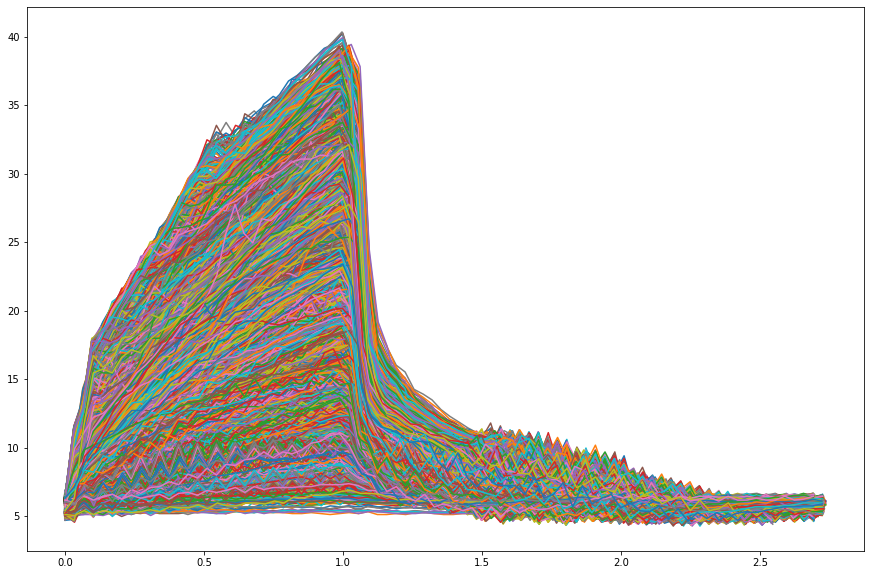

In [18]:
train_rc = train[(train['R']==5) & (train['C']==50)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')